
ReLU defense
==============================

**Author:** https://github.com/aliborji/ReLU_defense.git



In [9]:
%matplotlib inline

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [1]:
# def fgsm(self, x, y, targeted=False, eps=0.03, x_val_min=-1, x_val_max=1):
#     x_adv = Variable(x.data, requires_grad=True)
#     h_adv = self.net(x_adv)
#     if targeted:
#         cost = self.criterion(h_adv, y)
#     else:
#         cost = -self.criterion(h_adv, y)

#     self.net.zero_grad()
#     if x_adv.grad is not None:
#         x_adv.grad.data.fill_(0)
#     cost.backward()

#     x_adv.grad.sign_()
#     x_adv = x_adv - eps*x_adv.grad
#     x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


#     h = self.net(x)
#     h_adv = self.net(x_adv)

#     return x_adv, h_adv, h

In [24]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [2]:
# class myRelu(nn.Module):
#     def __init__(self, slope = 1):
#         super().__init__()
#         self.slope = slope

#     def forward(self, x):
#         return self.slope * torch.relu(x)

# class reluForward(torch.autograd.Function):
#   @staticmethod
#   def forward(self, inp, slope = 1):
#     #option1:
#     #return = inp * (inp>0).float()
#     #option2:
#     #return F.relu(inp).data
#     #option3:
#     s = torch.tensor(slope, requires_grad=False)
#     return s * F.relu(inp)

#   @staticmethod
#   def backward(self, grad_out, a):
#     return grad_out, a

# # To use it:
# inp = torch.tensor([4])# rand(3)
# out = reluForward(2).apply(inp) # Use the class here, not an instance of it !

# class reluForward(nn.Module):

#     def __init__(self, slope=0.9):
#         super().__init__()
#         self.slope = slope

#     def forward(self, x):
#         return self.slope * F.relu(x)

In [23]:
# simply define a silu function
def srelu(input, slope):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:

        SiLU(x) = x * sigmoid(x)
    '''
#     return input * torch.sigmoid(input) # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions
    return slope * F.relu(input)

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class SReLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
    
        SiLU(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf

    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input, slope):
        '''
        Forward pass of the function.
        '''
        return srelu(input, slope) # simply apply already implemented SiLU

In [26]:
# LeNet Model definition
class NetTest(nn.Module):
    def __init__(self, slope):
        super(NetTest, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.slope = slope

    def forward(self, x):
#         s = torch.tensor(.7, requires_grad=False)        
        x = srelu(F.max_pool2d(self.conv1(x), 2), self.slope)
        x = srelu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2), self.slope)    
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = srelu(self.fc1(x), self.slope)
#         x = F.relu(self.fc1(x))        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  ### SUPER IMPORTANT ***************************** works with nll loss loss now
#         return x  ### SUPER IMPORTANT ***************************** works with cross entropy loss loss now

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")



In [21]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "./models/lenet_mnist_model.pth"
use_cuda=False

In [16]:
# # accuracy on clean data

# # SKIP THIS!! It just computes score on clean data.
# slopes   = [.2, .5, 1, 2, 5, 10, 100]
# accs = []

# for sl in slopes:

#     # Initialize the network
#     model = NetTest(sl).to(device)

#     # Load the pretrained model
#     model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

#     # Set the model in evaluation mode. In this case this is for the Dropout layers
#     model.eval()


#     correct = 0
#     total = 0

#     for images, labels in test_loader:

#     #     images = images.cuda()
#         outputs = model(images)

#         _, predicted = torch.max(outputs, 1)

#         total += labels.size(0)
#         correct += (predicted == labels).sum()

#     print('Accuracy of Clean images: %f %%' % (100 * float(correct) / total))
    
#     accs.append((100 * float(correct) / total))

In [27]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
slopes   = [.2, .5, 1, 2, 5, 10, 100]

epsilons = [.1]
slopes   = [10]


all_accuracies = []
all_examples = []

# Run test for each slope
for sl in slopes:
    print(f'\n Running slope={sl} ... ')
    # Initialize the network
    model = NetTest(sl).to(device)

    # Load the pretrained model
    model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

    # Set the model in evaluation mode. In this case this is for the Dropout layers
    model.eval()
    
    # Run test for each epsilon
    accuracies = []
    examples = []
    
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
        
    all_accuracies.append(accuracies)
    all_examples.append(examples)
    


 Running slope=10 ... 
Epsilon: 0.1	Test Accuracy = 9781 / 10000 = 0.9781


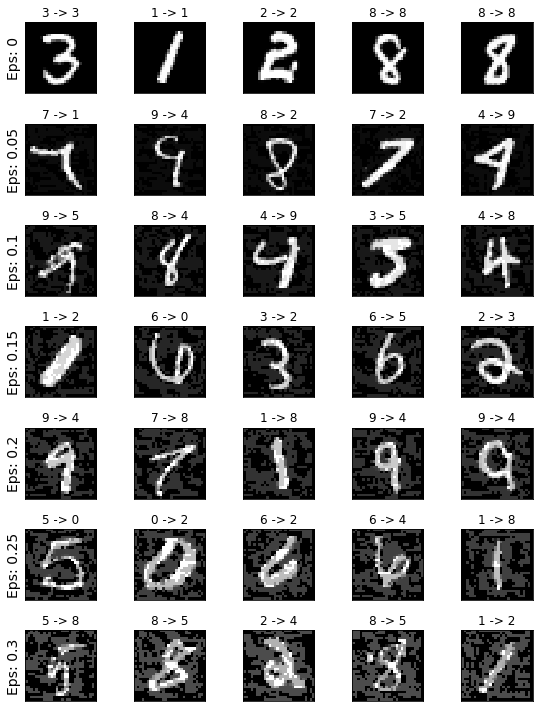

In [47]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

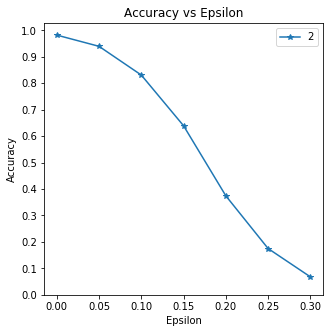

In [26]:
plt.figure(figsize=(5,5))
symbs = ['*-', 'o-', 's-', 'd-', '+-', 'x-', '^-']
for idx, sl in enumerate(all_accuracies):
    plt.plot(epsilons, sl, symbs[idx])
    
#     plt.plot(epsilons, np.array(all_accuracies).T, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(slopes)
plt.show()

In [370]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()
